# Silverbox

Silverbox refers to one of the nonlinear system identification benchmarks on http://nonlinearbenchmark.org/#Silverbox. 
It is a set of measurements of an electronic implementation of a [Duffing oscillator](https://en.wikipedia.org/wiki/Duffing_equation).

State-space model of the system:

$$\begin{align}
m \frac{d^2 x(t)}{dt^2} + v \frac{d x(t)}{dt} + a x(t) + b x^3(t) =&\ u(t) + w(t) \\
y(t) =&\ x(t) + e(t)
\end{align}$$

where
$$\begin{align}
m     =&\ \text{mass} \\
v     =&\ \text{viscous damping} \\
a     =&\ \text{linear stiffness} \\
b     =&\ \text{nonlinear stiffness} \\
y(t)    =&\ \text{observation (displacement)} \\
x(t)    =&\ \text{state (displacement)} \\
u(t)    =&\ \text{force} \\
e(t)    =&\ \text{measurement noise} \\
w(t)    =&\ \text{process noise}
\end{align}$$

The process noise is a Wiener process, where the increment is Gaussian distributed:

$$\begin{align}
w(t) =&\ \frac{d B(t)}{dt} \sim \mathcal{N}(0, \tau^{-1}dt)
\end{align}$$

The parameter $\tau$ represents the precision of the process. The same holds for the measurement noise.

## Solution steps

### 1. Ignore nonlinear stiffness

For now, we ignore the nonlinear stiffness component by setting the parameter $b$ to 0. The state transition thus reduces to:

$$\begin{align}
m x''(t) + v x'(t) + a x(t) = u(t) + w(t) 
\end{align}$$

### 2. Discretize using finite-differences

I'm using an implicit method, for stability reasons.
The backward difference for both derivative terms:

$$\begin{align}
x''(t) \approx&\ \frac{x(t) - 2x(t-h) + x(t-2h)}{h^2} = \frac{x_t - 2x_{t-1} + x_{t-2}}{(\Delta t)^2}\\
x'(t) \approx&\ \frac{x(t) - x(t-h)}{h} = \frac{x_t - x_{t-1}}{\Delta t}\\
\end{align}$$

where $\Delta t = t - (t-1) = 1$. A discretization of the Wiener process yields:

$$\begin{align}
w(t) = \frac{dB(t)}{dt} \approx \frac{B(t) - B(t-h)}{h} = \frac{B_t - B_{t-1}}{\Delta t} \sim \mathcal{N}(0, \tau^{-1}\Delta t) \, .
\end{align}$$

Let $w_t$ be a sample from $\mathcal{N}(0, \tau^{-1})$. The control signal $u(t)$ was constructed from a discrete signal, converted into an analogue signal through a zero-order-hold filter. That means it's a step-function: constant between any $t$ and $t-1$. Since it is an observed variable, we can just convert $u(t)$ straight to $u_t$. The DE can now be written as the following discrete-time system:

$$m (x_t - 2x_{t-1} + x_{t-2}) + v (x_t - x_{t-1}) + a x_t = u_t + w_t$$

Re-writing this in terms of $x_t$ yields:
$$\begin{align}
(m + v + a) x_t&\ + (-2m - v) x_{t-1} + m x_{t-2} = u_t + w_t \\
% x_t + \frac{-2m - v}{m + v + a} x_{t-1} + \frac{m}{m + v + a} x_{t-2} =&\ \frac{1}{m + v + a} u_t + \frac{1}{m + v + a} w_t \\
x_t&\ = \frac{2m + v}{m + v + a} x_{t-1} + \frac{-m}{m + v + a} x_{t-2} + \frac{1}{m + v + a} u_t + \frac{1}{m + v + a} w_t \, .
\end{align}$$


### 3. Substitute variables:

I'm substituting variables to clean the equation up a bit:

$$\begin{align} 
\theta_1 =&\ \frac{2m + v}{m + v + a} \\
\theta_2 =&\ \frac{-m}{m + v + a} \\
\eta =&\ \frac{1}{m + v + a} \, .
\end{align}$$

This produces:
$$\begin{align}
x_t = \theta_1 x_{t-1} + \theta_2 x_{t-2} + \eta u_t + \eta w_t
\end{align}$$

I'm going to absorb $\eta$ into $w_t$ (using $\mathbb{V}[aX] = a^2\mathbb{V}[X]$):

$$\begin{align}
\mathbb{V}[\eta w_t] = \eta^2 \mathbb{V}[w_t] = \eta^2 \tau^{-1}
\end{align}$$

I will rename $\eta^2 \tau^{-1}$ as $\gamma^{-1}$. This yields

$$\begin{align}
x_t = \theta_1 x_{t-1} + \theta_2 x_{t-2} + \eta u_t + \tilde{w}_t
\end{align}$$

where $\tilde{w}_t \sim \mathcal{N}(0, \gamma^{-1})$. Given four equations and four unknowns, I can recover $m$, $v$, $a$ and $\tau$ from $\theta_1$, $\theta_2$, $\eta$ and $\gamma$.

### 4. Cast to multivariate first-order form

The system now resembles an auto-regressive process:

$$ \underbrace{\begin{bmatrix} x_t \\ x_{t-1} \end{bmatrix}}_{z_t} = \underbrace{\begin{bmatrix} \theta_1 & \theta_2 \\ 1 & 0 \end{bmatrix}}_{A(\theta)} \underbrace{\begin{bmatrix} x_{t-1} \\ x_{t-2} \end{bmatrix}}_{z_{t-1}} + \underbrace{\begin{bmatrix} \eta \\ 0 \end{bmatrix}}_{B(\eta)} u_t + \begin{bmatrix} 1 \\ 0 \end{bmatrix} \tilde{w}_t \, .$$

Note that we need a two-dimensional state prior now (reminiscent of adding an initial condition on the velocity).

### 5. Convert to Gaussian probability

The state transition maps to

$$z_t \sim \mathcal{N}(A(\theta) z_{t-1} + c\eta u_t, V)$$

where $V = \begin{bmatrix} \gamma^{-1} & 0 \\ 0 & \epsilon \end{bmatrix}$ and $V^{-1} = W = \begin{bmatrix} \gamma & 0 \\ 0 & \epsilon^{-1} \end{bmatrix}$.

The observation likelihood maps to

$$y_t \sim \mathcal{N}(c^{\top} z_t, \xi^{-1})$$

where $c = \begin{bmatrix} 1 & 0 \end{bmatrix}$ and $e_t \sim \mathcal{N}(0, \xi^{-1})$.

### 6. Choose priors

We currently have unknown parameters $\psi = (\theta_1, \theta_2, \eta, \gamma)$. Since they are substitutions, we don't know anything about their support directly. We do know about it indirectly, from the nonlinear combinations of the physical coefficients. We know that mass $m$ and process precision $\gamma$ are strictly positive parameters and that the damping and stiffness coefficients can be both positive and negative. Hence, by examing the nonlinear transform $\psi = G(\phi)$;

$$\begin{align} 
\theta_1 =&\ \frac{2m + v}{m + v + a} \\
\theta_2 =&\ \frac{-m}{m + v + a} \\
\eta =&\ \frac{1}{m + v + a} \\
\gamma^{-1} =&\ \frac{1}{\tau(m + v+ a)^2} \, .
\end{align}$$

we realize that $\theta_1$, $\theta_2$ and $\eta$ can be both positive and negative, but $\gamma$ can only be positive. As such, we choose the following priors:

$$\begin{align}
\theta \sim&\ \mathcal{N}(m^{0}_{\theta}, V^{0}_{\theta}) \\
\eta \sim&\ \mathcal{N}(m^{0}_{\eta}, v^{0}_{\eta}) \\ 
\gamma \sim&\ \Gamma(a^{0}_\gamma, b^{0}_\gamma) 
\end{align}$$

Modeling $\theta = (\theta_1, \theta_2)$ as a joint Gaussian allows for incorporating it into an Autoregressive node.

### 7. Recover physical variables from substituted ones

Since we have four equations and four unknowns, we can perfectly recover point estimates of the physical variables from substituted ones. However, we don't want point estimates, we want posteriors. 

If we approximate $\gamma$ with a log-Normal distribution and then map it to a Gaussian distribution (i.e. model $\log(\gamma)$), we end up with a Gaussian distributed random vector $\psi = [\theta_1, \theta_2, \eta, \log(\gamma)]$. We can perform a Gaussian approximation of the inverse mapping $G^{-1}(\psi)$ using a first-order Taylor expansion:

$$\begin{align}
m_{\phi} \triangleq \mathbb{E}[G^{-1}(\psi)] =&\ G^{-1}(m_{\psi} \\
V_{\phi} \triangleq \mathbb{V}[G^{-1}(\psi)] =&\ J_{\psi}(m_{\psi}) G^{-1}(m_{\psi} J_{\psi}(m_{\psi})^{\top} \, ,
\end{align}$$

Since each component of $\phi$ is Gaussian distributed, we have actually modeled $\log(m)$ and $\log(\tau)$. We still need to map these to log-Normal distributions to recover $m$ and $\tau$.

### Data

Let's first have a look at the data.

In [1]:
using Revise
using CSV
using DataFrames

In [2]:
using Plots
viz = false;

In [3]:
# Read data from CSV file
df = CSV.read("../data/SNLS80mV.csv", ignoreemptylines=true)
df = select(df, [:V1, :V2])

# Shorthand
input = df[:,1]
output = df[:,2]

# Time horizon
T = size(df, 1);

In [4]:
# Plot every n-th time-point to avoid figure size exploding
n = 10;

In [5]:
# Plot output signal (observed displacement)
if viz  
    p1 = Plots.scatter(1:n:T, output[1:n:T], color="black", label="output", markersize=2, size=(1600,800), xlabel="time (t)", ylabel="response")
    # Plots.savefig(p1, "viz/output_signal.png")
end

In [6]:
# Plot input signal (control)
if viz
    p2 = Plots.scatter(1:n:T, input[1:n:T], color="blue", label="output", markersize=2, size=(1600,800), xlabel="time (t)", ylabel="control")
    # Plots.savefig(p2, "viz/input_signal.png")
end

## Estimating parameters via Bayesian filtering

Implementation with ForneyLab and AR node. The AR node is locally modified from the package LAR (LAR is in dev mode).

In [7]:
using LinearAlgebra
using ForneyLab
import ForneyLab: unsafeMean, unsafeCov, unsafeVar, unsafePrecision
# using LAR
using LAR.Node
using LAR.Data
using ProgressMeter

In [8]:
using Zygote

function Jacobian(F, x)
    y = F(x)
    n = length(y)
    m = length(x)
    T = eltype(y)
    j = Array{T, 2}(undef, n, m)
    for i in 1:n
        j[i, :] .= gradient(x -> F(x)[i], x)[1]
    end
    return j
end;

In [31]:
# Start graph
graph = FactorGraph()

# Coefficients
@RV θ ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(2,)), placeholder(:w_θ, dims=(2,2)))
@RV η ~ GaussianMeanPrecision(placeholder(:m_η), placeholder(:w_η))
@RV γ ~ Gamma(placeholder(:a_γ), placeholder(:b_γ))
@RV ξ ~ Gamma(placeholder(:a_ξ), placeholder(:b_ξ))
@RV u_t

# State prior
@RV x_t_prev ~ GaussianMeanPrecision(placeholder(:m_x_t_prev, dims=(2,)), placeholder(:w_x_t_prev, dims=(2, 2)))

# Autoregressive node
@RV x_t ~ Autoregressive(θ, x_t_prev, γ)

# Control term
@RV Bu = [1., 0.]*(u_t*η)

# Add control
@RV z_t = x_t + Bu

# Select first element
@RV z_1 = dot([1., 0.], z_t)

# Specify likelihood
@RV y_t ~ GaussianMeanPrecision(z_1, ξ)

# Placeholders
placeholder(y_t, :y_t)
placeholder(u_t, :u_t)

# Draw time-slice subgraph
ForneyLab.draw(graph)

# Inference algorithm
q = PosteriorFactorization([x_t, x_t_prev], θ, γ, ξ, ids=[:x, :θ, :γ, :ξ])
# q = PosteriorFactorization([z_t, x_t_prev], θ, η, γ, ξ, ids=[:x, :θ, :η, :γ, :ξ])
algo = variationalAlgorithm(q, free_energy=true)
source_code = algorithmSourceCode(algo, free_energy=true)
eval(Meta.parse(source_code))
println(source_code)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 13855505645924924685 -->
 
 13855505645924924685 
 
 × 
 multiplication_1 
 
<!-- 14028703354723999061 -->
 
 14028703354723999061 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 13855505645924924685--14028703354723999061 -->
 
 13855505645924924685--14028703354723999061 
 
 η 
 1 out 
 2 in1 
 
<!-- 10847027611116326287 -->
 
 10847027611116326287 
 
 placeholder_m_θ 
 
<!-- 6602253572998407801 -->
 
 6602253572998407801 
 
 placeholder_w_θ 
 
<!-- 12993740601223341665 -->
 
 12993740601223341665 
 
 placeholder_y_t 
 
<!-- 16640233083970539312 -->
 
 16640233083970539312 
 
 𝒩 
 gaussianmeanprecision_4 
 
<!-- 12993740601223341665--16640233083970539312 -->
 
 12993740601223341665--16640233083970539312 
 
 y_t 
 1 out 
 1 out 
 
<!-- 12309261111891549833 -->
 
 12309261111891549833 
 
 placeholder_m_η 
 
<!-- 14028703354723999061--12309261111891549833 -->
 
 14028703354723999061--12309261111891549833 
 
 m_η 
 1 out 
 2 m 
 
<!-- 15391426133524184612 -->
 
 15391426133524184612 
 
 placeholder_w_η 
 
<!-- 14028703354723999061--15391426133524184612 -->
 
 14028703354723999061--15391426133524184612 
 
 w_η 
 1 out 
 3 w 
 
<!-- 17810315253613801001 -->
 
 17810315253613801001 
 
 placeholder_a_ξ 
 
<!-- 14708370857454366077 -->
 
 14708370857454366077 
 
 placeholder_w_x_t_prev 
 
<!-- 9455481586196314142 -->
 
 9455481586196314142 
 
 placeholder_m_x_t_prev 
 
<!-- 2387184091083283321 -->
 
 2387184091083283321 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 2387184091083283321--14708370857454366077 -->
 
 2387184091083283321--14708370857454366077 
 
 w_x_t_prev 
 1 out 
 3 w 
 
<!-- 2387184091083283321--9455481586196314142 -->
 
 2387184091083283321--9455481586196314142 
 
 m_x_t_prev 
 1 out 
 2 m 
 
<!-- 2617742700906269812 -->
 
 2617742700906269812 
 
 Gam 
 gamma_1 
 
<!-- 5825970132603642639 -->
 
 5825970132603642639 
 
 placeholder_b_γ 
 
<!-- 2617742700906269812--5825970132603642639 -->
 
 2617742700906269812--5825970132603642639 
 
 b_γ 
 1 out 
 3 b 
 
<!-- 13597594167765430214 -->
 
 13597594167765430214 
 
 placeholder_a_γ 
 
<!-- 2617742700906269812--13597594167765430214 -->
 
 2617742700906269812--13597594167765430214 
 
 a_γ 
 1 out 
 2 a 
 
<!-- 4841225792198115994 -->
 
 4841225792198115994 
 
 clamp_1 
 
<!-- 2616821376982118119 -->
 
 2616821376982118119 
 
 placeholder_b_ξ 
 
<!-- 13070222247589973747 -->
 
 13070222247589973747 
 
 dot 
 dotproduct_1 
 
<!-- 11207164347059506575 -->
 
 11207164347059506575 
 
 clamp_2 
 
<!-- 13070222247589973747--11207164347059506575 -->
 
 13070222247589973747--11207164347059506575 
 
 clamp_2 
 1 out 
 3 in2 
 
<!-- 5798854174128000431 -->
 
 5798854174128000431 
 
 + 
 addition_1 
 
<!-- 13070222247589973747--5798854174128000431 -->
 
 13070222247589973747--5798854174128000431 
 
 z_t 
 1 out 
 2 in1 
 
<!-- 3061090116126736620 -->
 
 3061090116126736620 
 
 Gam 
 gamma_2 
 
<!-- 3061090116126736620--17810315253613801001 -->
 
 3061090116126736620--17810315253613801001 
 
 a_ξ 
 1 out 
 2 a 
 
<!-- 3061090116126736620--2616821376982118119 -->
 
 3061090116126736620--2616821376982118119 
 
 b_ξ 
 1 out 
 3 b 
 
<!-- 5779065836003893712 -->
 
 5779065836003893712 
 
 AR 
 autoregressive_1 
 
<!-- 5798854174128000431--5779065836003893712 -->
 
 5798854174128000431--5779065836003893712 
 
 x_t 
 1 y 
 2 in1 
 
<!-- 9566614541240573429 -->
 
 9566614541240573429 
 
 × 
 multiplication_2 
 
<!-- 5798854174128000431--9566614541240573429 -->
 
 5798854174128000431--9566614541240573429 
 
 Bu 
 1 out 
 3 in2 
 
<!-- 5779065836003893712--2387184091083283321 -->
 
 5779065836003893712--2387184091083283321 
 
 x_t_prev 
 1 out 
 2 x 
 
<!-- 5779065836003893712--2617742700906269812 -->
 
 5779065836003893712--2617742700906269812 
 
 γ 
 1 o

begin

function stepγ!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = ruleVBGammaOut(nothing, ProbabilityDistribution(Univariate, PointMass, m=data[:a_γ]), ProbabilityDistribution(Univariate, PointMass, m=data[:b_γ]))
messages[2] = ruleSVariationalARIn3PPPN(marginals[:x_t_x_t_prev], marginals[:θ], nothing)

marginals[:γ] = messages[1].dist * messages[2].dist

return marginals

end

function stepξ!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = ruleVBGammaOut(nothing, ProbabilityDistribution(Univariate, PointMass, m=data[:a_ξ]), ProbabilityDistribution(Univariate, PointMass, m=data[:b_ξ]))
messages[2] = ruleVBGaussianMeanPrecisionW(ProbabilityDistribution(Univariate, PointMass, m=data[:y_t]), marginals[:z_1], nothing)

marginals[:ξ] = messages[1].dist * messages[2].dist

return marginals

end

function stepθ!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{

In [ ]:
begin

function stepγ!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = ruleVBGammaOut(nothing, ProbabilityDistribution(Univariate, PointMass, m=data[:a_γ]), ProbabilityDistribution(Univariate, PointMass, m=data[:b_γ]))
messages[2] = ruleSVariationalARIn3PPPN(marginals[:x_t_x_t_prev], marginals[:θ], nothing)

marginals[:γ] = messages[1].dist * messages[2].dist

return marginals

end

function stepξ!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = ruleVBGammaOut(nothing, ProbabilityDistribution(Univariate, PointMass, m=data[:a_ξ]), ProbabilityDistribution(Univariate, PointMass, m=data[:b_ξ]))
messages[2] = ruleVBGaussianMeanPrecisionW(ProbabilityDistribution(Univariate, PointMass, m=data[:y_t]), marginals[:z_1], nothing)

marginals[:ξ] = messages[1].dist * messages[2].dist

return marginals

end

function stepθ!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = ruleVBGaussianMeanPrecisionOut(nothing, ProbabilityDistribution(Multivariate, PointMass, m=data[:m_θ]), ProbabilityDistribution(MatrixVariate, PointMass, m=data[:w_θ]))
messages[2] = ruleSVariationalARIn2PPNP(marginals[:x_t_x_t_prev], nothing, marginals[:γ])

marginals[:θ] = messages[1].dist * messages[2].dist

return marginals

end

function stepx!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 14))

messages[1] = ruleVBGaussianMeanPrecisionOut(nothing, ProbabilityDistribution(Univariate, PointMass, m=data[:m_η]), ProbabilityDistribution(Univariate, PointMass, m=data[:w_η]))
messages[2] = ruleVBGaussianMeanPrecisionM(ProbabilityDistribution(Univariate, PointMass, m=data[:y_t]), nothing, marginals[:ξ])
messages[3] = ruleSPDotProductIn1GNP(messages[2], nothing, Message(Multivariate, PointMass, m=[1.0, 0.0]))
messages[4] = ruleVBGaussianMeanPrecisionOut(nothing, ProbabilityDistribution(Multivariate, PointMass, m=data[:m_x_t_prev]), ProbabilityDistribution(MatrixVariate, PointMass, m=data[:w_x_t_prev]))
messages[5] = ruleSVariationalAROutNPPP(nothing, messages[4], marginals[:θ], marginals[:γ])
messages[6] = ruleSPAdditionIn2GGN(messages[3], messages[5], nothing)
messages[7] = ruleSPMultiplicationIn1GNP(messages[6], nothing, Message(Multivariate, PointMass, m=[1.0, 0.0]))
messages[8] = ruleSPMultiplicationIn1GNP(messages[7], nothing, Message(Univariate, PointMass, m=data[:u_t]))
messages[9] = ruleSPMultiplicationOutNGP(nothing, messages[1], Message(Univariate, PointMass, m=data[:u_t]))
messages[10] = ruleSPMultiplicationOutNGP(nothing, messages[9], Message(Multivariate, PointMass, m=[1.0, 0.0]))
messages[11] = ruleSPAdditionOutNGG(nothing, messages[5], messages[10])
messages[12] = ruleSPDotProductOutNGP(nothing, messages[11], Message(Multivariate, PointMass, m=[1.0, 0.0]))
messages[13] = ruleSPAdditionIn1GNG(messages[3], nothing, messages[10])
messages[14] = ruleSVariationalARIn1PNPP(messages[13], nothing, marginals[:θ], marginals[:γ])

marginals[:variable_2] = messages[10].dist * messages[6].dist
marginals[:x_t] = messages[5].dist * messages[13].dist
marginals[:x_t_prev] = messages[4].dist * messages[14].dist
marginals[:z_1] = messages[12].dist * messages[2].dist
marginals[:η] = messages[1].dist * messages[8].dist
marginals[:x_t_variable_2] = ruleMAdditionNGG(messages[3], messages[5], messages[10])
marginals[:x_t_x_t_prev] = ruleMGaussianMeanVarianceGGGD(messages[13], messages[4], marginals[:θ], marginals[:γ])

return marginals

end

function freeEnergy(data::Dict, marginals::Dict)

F = 0.0

F += averageEnergy(Autoregressive, marginals[:x_t_x_t_prev], marginals[:θ], marginals[:γ])
F += averageEnergy(Gamma, marginals[:γ], ProbabilityDistribution(Univariate, PointMass, m=data[:a_γ]), ProbabilityDistribution(Univariate, PointMass, m=data[:b_γ]))
F += averageEnergy(Gamma, marginals[:ξ], ProbabilityDistribution(Univariate, PointMass, m=data[:a_ξ]), ProbabilityDistribution(Univariate, PointMass, m=data[:b_ξ]))
F += averageEnergy(GaussianMeanPrecision, marginals[:θ], ProbabilityDistribution(Multivariate, PointMass, m=data[:m_θ]), ProbabilityDistribution(MatrixVariate, PointMass, m=data[:w_θ]))
F += averageEnergy(GaussianMeanPrecision, marginals[:η], ProbabilityDistribution(Univariate, PointMass, m=data[:m_η]), ProbabilityDistribution(Univariate, PointMass, m=data[:w_η]))
F += averageEnergy(GaussianMeanPrecision, marginals[:x_t_prev], ProbabilityDistribution(Multivariate, PointMass, m=data[:m_x_t_prev]), ProbabilityDistribution(MatrixVariate, PointMass, m=data[:w_x_t_prev]))
F += averageEnergy(GaussianMeanPrecision, ProbabilityDistribution(Univariate, PointMass, m=data[:y_t]), marginals[:z_1], marginals[:ξ])

F -= -1*differentialEntropy(marginals[:variable_2])
F -= -1*differentialEntropy(marginals[:x_t])
F -= differentialEntropy(marginals[:x_t_variable_2])
F -= differentialEntropy(marginals[:x_t_x_t_prev])
F -= differentialEntropy(marginals[:γ])
F -= differentialEntropy(marginals[:η])
F -= differentialEntropy(marginals[:θ])
F -= differentialEntropy(marginals[:ξ])

return F

end

end # block

In [33]:
# Looking at only the first few timepoints
# T = 100
T = size(df, 1);

# Inference parameters
num_iterations = 10

# Initialize marginal distribution and observed data dictionaries
data = Dict()
marginals = Dict()

# Initialize arrays of parameterizations
params_x = (zeros(2,T+1), repeat(.1 .*float(eye(2)), outer=(1,1,T+1)))
params_θ = (ones(2,T+1), repeat(.1 .*float(eye(2)), outer=(1,1,T+1)))
params_η = (ones(1,T+1), .1*ones(1,T+1))
params_γ = (ones(1,T+1), ones(1,T+1))
params_ξ = (1e4*ones(1,T+1), 1e1*ones(1,T+1))

# Initialize physical coefficient estimate arrays
params_m = (zeros(T,), zeros(T,))
params_v = (zeros(T,), zeros(T,))
params_a = (zeros(T,), zeros(T,))
params_τ = (zeros(T,), zeros(T,))

# Initialize message array
messages = Array{Message}(undef, 14)

# Initialize free energy array
FE = zeros(T,num_iterations)

# Start progress bar
p = Progress(T, 1, "At time ")

# Perform inference at each time-step
for t = 1:T

    # Update progress bar
    update!(p, t)
    
    "Filtering"

    # Initialize marginals
    marginals[:x_t_x_t_prev] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=zeros(4,), w=float(eye(4)))
    marginals[:x_t_prev] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_x[1][:,t], w=params_x[2][:,:,t])
    marginals[:x_t_Bu] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=zeros(2,), w=float(eye(2)))
    marginals[:x_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_x[1][:,t], w=params_x[2][:,:,t])
    marginals[:z_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_x[1][:,t], w=params_x[2][:,:,t])
    marginals[:z_1] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=params_x[1][1,t], w=params_x[2][1,1,t])
    marginals[:Bu] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=zeros(2,), w=float(eye(2)))
    marginals[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_θ[1][:,t], w=params_θ[2][:,:,t])
    marginals[:η] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=params_η[1][1,t], w=params_η[2][1,t])
    marginals[:γ] = ProbabilityDistribution(Univariate, Gamma, a=params_γ[1][1,t], b=params_γ[2][1,t])
    marginals[:ξ] = ProbabilityDistribution(Univariate, Gamma, a=params_ξ[1][1,t], b=params_ξ[2][1,t])
    
    # Set clamped variables
    data = Dict(:y_t => output[t],
                :u_t => input[t],
                :m_x_t_prev => params_x[1][:,t],
                :w_x_t_prev => params_x[2][:,:,t],
                :m_θ => params_θ[1][:,t],
                :w_θ => params_θ[2][:,:,t],
                :m_η => params_η[1][1,t],
                :w_η => params_η[2][1,t],
                :a_γ => params_γ[1][1,t],
                :b_γ => params_γ[2][1,t],
                :a_ξ => params_ξ[1][1,t],
                :b_ξ => params_ξ[2][1,t])
    
    # Iterate variational parameter updates
    for i = 1:num_iterations
        
        # Compute Free Energy
        FE[t,i] = freeEnergy(data, marginals)

        # Update recognition factors
        stepx!(data, marginals, messages)
        stepθ!(data, marginals)
#         stepη!(data, marginals)
        stepγ!(data, marginals)
        stepξ!(data, marginals)
        
        # Update marginal of z_t manually
        marginals[:z_t] = messages[13].dist*messages[3].dist
    end
    
    # Store current parameterizations of marginals
    params_x[1][:,t+1] = mean(marginals[:z_t])
    params_x[2][:,:,t+1] = marginals[:z_t].params[:w]
    params_θ[1][:,t+1] = mean(marginals[:θ])
    params_θ[2][:,:,t+1] = marginals[:θ].params[:w]
    params_η[1][1,t+1] = mean(marginals[:η])
    params_η[2][1,t+1] = marginals[:η].params[:w]
    params_γ[1][1,t+1] = marginals[:γ].params[:a]
    params_γ[2][1,t+1] = marginals[:γ].params[:b]
    params_ξ[1][1,t+1] = marginals[:ξ].params[:a]
    params_ξ[2][1,t+1] = marginals[:ξ].params[:b]
    
    "Map substituted to physical variables via first-order Taylor"
    
    # Approximate gamma with log-normal via moment-matching
    Eγ = unsafeMean(marginals[:γ])
    Vγ = unsafeVar(marginals[:γ])
    m_γ = log(Eγ^2/sqrt(Vγ + Eγ^2))
    v_γ = log(Vγ/Eγ^2 + 1)

    # Construct vector of parameter estimates ψ
    m_ψ = [unsafeMean(marginals[:θ])[1], unsafeMean(marginals[:θ])[2], unsafeMean(marginals[:η])[1], m_γ]
    V_ψ = [unsafeCov(marginals[:θ]) zeros(2,2); zeros(2,2) [unsafeCov(marginals[:η])[1,1] 0;0 v_γ]]

    # Transformation: ψ = G(ϕ) => ϕ = G_inv(ψ)
    G_inv(ψ) = [-ψ[2]/ψ[3], (ψ[1] + 2*ψ[2])/ψ[3], (-ψ[1] -ψ[2] +1)/ψ[3], ψ[4]/ψ[3]^2]
    
    # Compute Jacobian of transformation 
    J_mϕ = Jacobian(G_inv, m_ψ)
    
    # Compute moments of transformed Gaussian using first-order Taylor approx
    m_ϕ = G_inv(m_ψ)
    V_ϕ = J_mϕ*V_ψ*J_mϕ'

    # Split ϕ into physical coefficients
    m_m, m_v, m_a, m_τ = m_ϕ
    v_m, v_v, v_a, v_τ = Diagonal(V_ϕ)
    
    # Store param estimates for mass
    params_m[1][t] = m_m
    params_m[2][t] = v_m
    
    # Store param estimates for friction
    params_v[1][t] = m_v
    params_v[2][t] = v_v
    
    # Store param estimates for linear stiffness
    params_a[1][t] = m_a
    params_a[2][t] = v_a
    
    # Store param estimates for process precision
    params_τ[1][t] = m_τ
    params_τ[2][t] = v_τ

end

At time 100%|███████████████████████████████████████████| Time: 0:22:0939m


### Visualize results

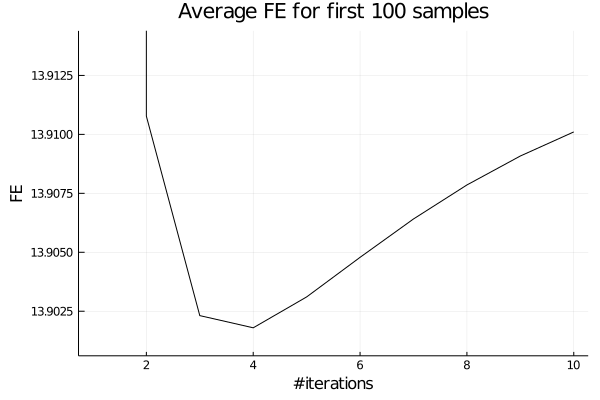

In [56]:
# Visualize FE
p00 = plot(mean(FE[1:100,1:end], dims=1)', color="black", ylabel="FE", xlabel="#iterations", label="", legend=:topleft, title="Average FE for first 100 samples", ylims=[13.901, 13.914])
# Plots.savefig(p00, "viz/FE_t_first100.png")

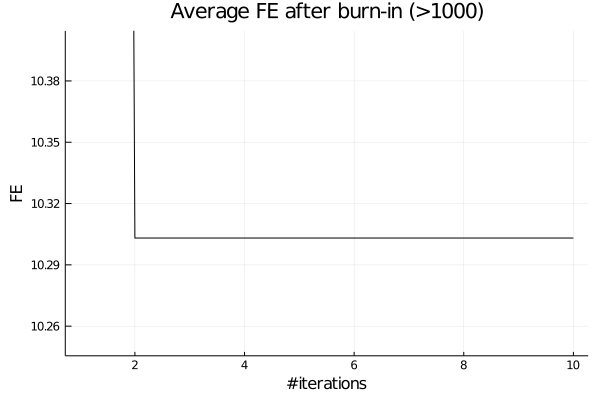

In [57]:
# Visualize FE
p02 = plot(mean(FE[1001:end,:], dims=1)', color="black", ylabel="FE", xlabel="#iterations", label="", legend=:topleft, title="Average FE after burn-in (>1000)", ylims=[10.25, 10.4])
# Plots.savefig(p02, "viz/FE_t_1000onwards.png")

In [58]:
# Visualize FE over time
p01 = plot(FE[:,end], color="black", ylabel="FE_t", xlabel="time (t)", label="", title="Final FE at each time step", ylims=[10., 13.])
# Plots.savefig(p01, "viz/FE_t.png")

In [49]:
# Plot every n-th time-point to avoid large figure filesizes
n = 20;

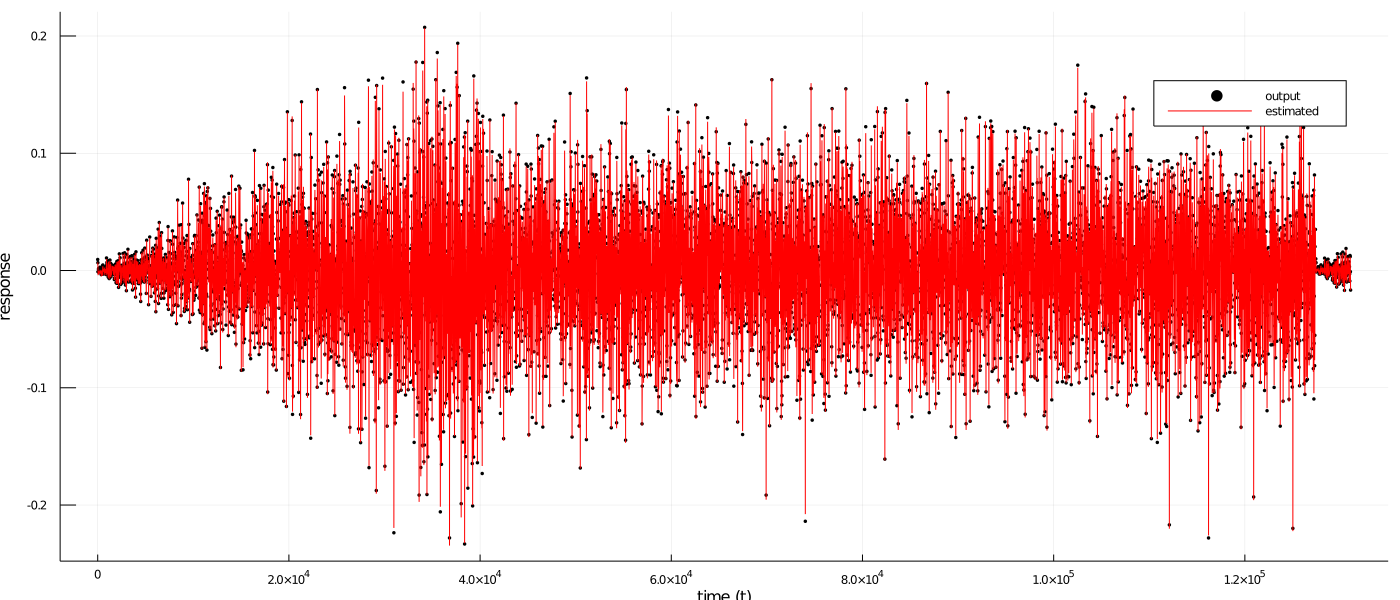

In [50]:
# Plot estimated states
p1 = Plots.scatter(1:n:T, output[1:n:T], color="black", label="output", markersize=2, size=(1400,600), xlabel="time (t)", ylabel="response")
Plots.plot!(1:n:T, params_x[1][1,2:n:end], color="red", linewidth=1, label="estimated")
# Plots.savefig(p1, "viz/estimated_states01.png")

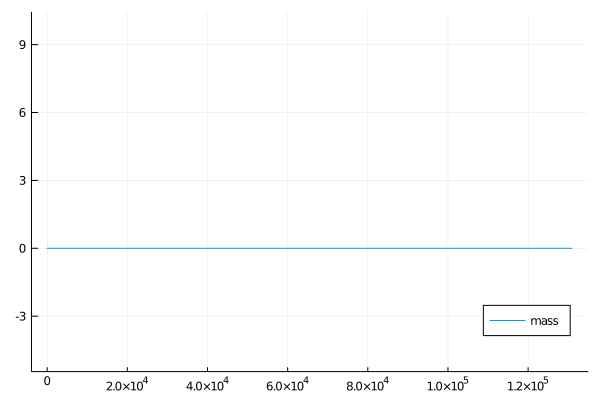

In [51]:
# Visualize estimates of mass
plot(1:n:T, params_m[1][2:n:T], ribbon=[sqrt.(params_m[2][2:n:T]) sqrt.(params_m[2][2:n:T])], label="mass", legend=:bottomright, ylim=[-5.,10.])

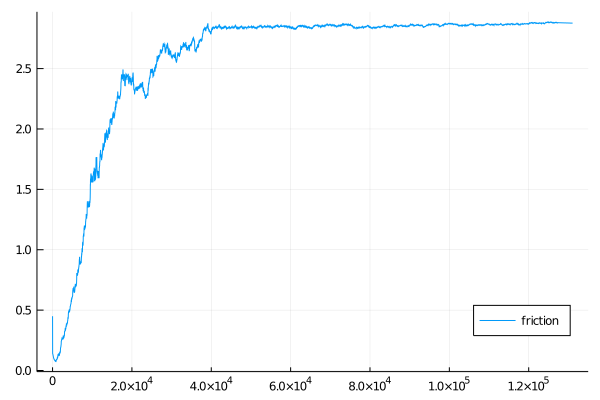

In [52]:
# Visualize estimates of friction
plot(1:n:T, params_v[1][1:n:T], ribbon=[sqrt.(params_v[2][1:n:T]) sqrt.(params_v[2][1:n:T])], label="friction", legend=:bottomright)

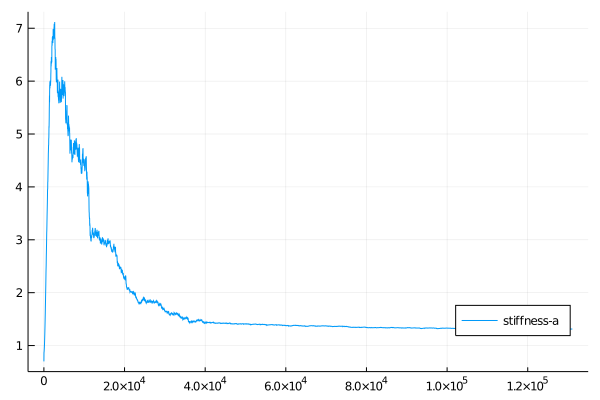

In [53]:
# Visualize estimates of linear stiffness
plot(1:n:T, params_a[1][1:n:T], ribbon=[sqrt.(params_a[2][1:n:T]) sqrt.(params_a[2][1:n:T])], label="stiffness-a", legend=:bottomright)

In [54]:
# Visualize estimates of process noise
plot(1:n:T, params_τ[1][1:n:T], ribbon=[sqrt.(params_τ[2][1:n:T]) sqrt.(params_τ[2][1:n:T])], label="process-noise", legend=:bottomright, yscale=:log10)

DomainError: DomainError with -0.7025448450013723:
NaN result for non-NaN input.

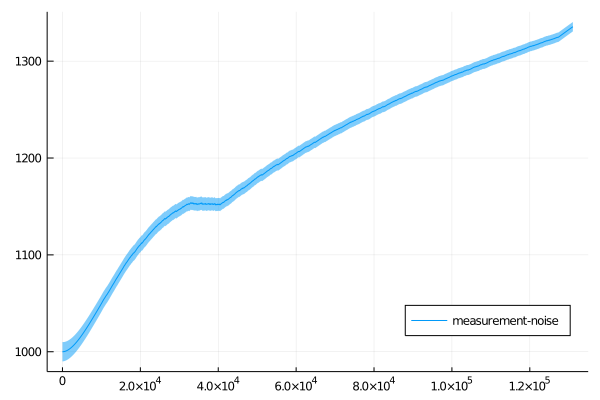

In [55]:
# Visualize estimates of measurement noise
mean_ξ_inv = params_ξ[1] ./ params_ξ[2]
var_ξ_inv = params_ξ[1] ./ params_ξ[2].^2
plot(1:n:T, mean_ξ_inv[1:n:T], ribbon=[sqrt.(var_ξ_inv[1:n:T]) sqrt.(var_ξ_inv[1:n:T])], label="measurement-noise", legend=:bottomright)